# Feature Selection
Time to exact some audio features! I'm going to be using the python package librosa to extract and visualize the mel spectrogram, chroma features, mel-frequency cepstral coefficients, spectral centroid and spectral rolloff.

In [1]:
# Import Packages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Audio Processing
import librosa
import librosa.feature as lf
import librosa.display as ld
import sounddevice as sd
import soundfile as sf

In [2]:
# open the legend
data = pd.read_csv('Data/CSVs/Audio Legend Clean.csv',index_col='Unnamed: 0')
purple = [0.267004, 0.004874, 0.329415, 1.]

# Get Features
open wav files and save features in a dataframe.

In [3]:
columns = ['filename','audio','sample rate','mel spectrogram','chroma','mel cepstral','centroid','rolloff']

audio = pd.DataFrame(columns=columns)
error = []

folders = 'Data/Audio/Clean/'
for count,track in enumerate(data['filename'],start=1):
    # get autio and sample rate
    path = folders+track
    clip, samplerate = librosa.load(path, sr=16000)
    try:
        L = [track,clip,samplerate,
             lf.melspectrogram(clip,samplerate),      # mel-frequency spectrogram
             lf.chroma_stft(clip,samplerate),         # chroma features
             lf.mfcc(clip,samplerate),                # mel-frequency cepstral coefficients
             lf.spectral_centroid(clip,samplerate),   # spectral centroid
             lf.spectral_rolloff(clip,samplerate)]    # spectral roll off
        audio = audio.append(dict(zip(columns,L)),ignore_index=True)
    except:
        error.append(track)
    
    # progress bar
    print('%4d of %4d complete (%d%%)' % (count,len(data['filename']),(count/len(data['filename']))*100)
          ,end='\r')
    
audio.index = pd.RangeIndex(0,len(audio))
audio.head(3)

,filename,audio,sample rate,mel spectrogram,chroma,mel cepstral,centroid,rolloff
0,Clip_0000.wav,"[0.0053100586, 0.0051574707, 0.0054016113, 0.0...",16000,"[[0.002243551, 0.011167973, 0.026370432, 0.006...","[[0.31399313, 0.3416271, 0.29401675, 0.0826690...","[[-173.28368, -54.43142, -14.931408, -36.94705...","[[2522.613417999448, 1998.7843665812868, 1773....","[[4335.9375, 3843.75, 3554.6875, 2945.3125, 26..."
1,Clip_0001.wav,"[0.0020446777, -0.00039672852, -0.0011291504, ...",16000,"[[0.0011843091, 0.0028443562, 0.0011252087, 0....","[[0.87314206, 0.7617242, 0.9011862, 0.7413292,...","[[-189.0959, -135.91434, -110.33126, -131.5426...","[[1944.9635382810397, 1662.5306125071847, 1536...","[[3804.6875, 2875.0, 2742.1875, 2625.0, 2414.0..."
2,Clip_0002.wav,"[0.0064086914, 0.0051574707, 0.0073547363, 0.0...",16000,"[[0.017193925, 0.030587701, 0.011005114, 0.001...","[[0.48194504, 0.24107023, 0.18023169, 0.284793...","[[-89.319405, -39.952785, -37.663242, -79.6460...","[[1783.0493082735893, 1807.4002671676599, 1685...","[[3539.0625, 3554.6875, 3148.4375, 2992.1875, ..."


# Visualize Features

In [4]:
import warnings
warnings.filterwarnings("ignore",category=UserWarning)

# set some variables for the plots
dpi = 100
width = 8

# Get a random audio clip
n = np.random.randint(0,len(audio))
test = audio.loc[n]
print(data[data['filename']==test['filename']][['original','statment','emotion']])

# Uncomment to hear the audio clip
#sd.play(test['audio'], test['sample rate'])
#status = sd.wait()

                      original  statment  emotion
7625  03-01-02-02-01-02-05.wav         1  neutral


### Waveform
The waveform is the general shape of the audio clip over time. This wont be included as a feature for modeling, but it's still nice to visualize and compare with the other features.

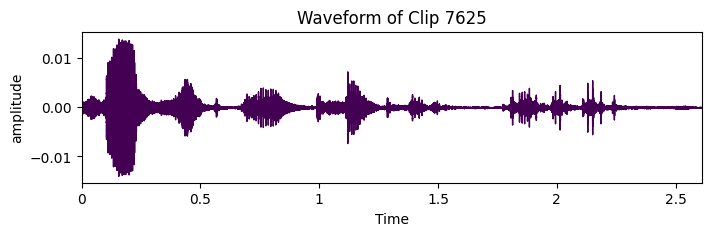

In [5]:
wave = test['audio']
sample_rate = test['sample rate']

plt.figure(figsize=(width,2),dpi=dpi)
ld.waveplot(wave, sr=sample_rate,color=purple)
plt.title('Waveform of Clip %-4d' % n)
plt.ylabel('amplitude');

### Mel-Frequency Spectrogram
A visualization of how the spectrum of frequencies changes over time. This spectrogram in particular utilizes the mel scale, which is a scale of pitches based on human hearing. 

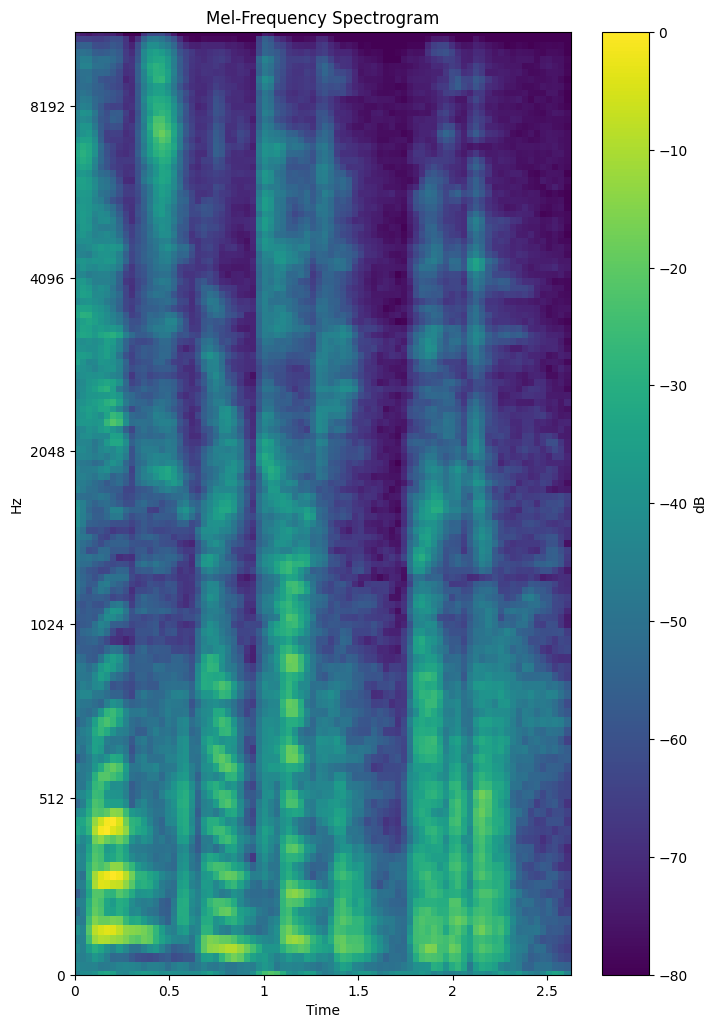

In [6]:
shape_y,shape_x = test['mel spectrogram'].shape
shape_y = (width/shape_x)*shape_y

plt.figure(figsize=(width,shape_y),dpi=dpi)
S_dB = librosa.power_to_db(test['mel spectrogram'], ref=np.max)
librosa.display.specshow(data=S_dB,sr=sample_rate, x_axis='time',y_axis='mel',cmap='viridis')
plt.colorbar(label='dB')
plt.title('Mel-Frequency Spectrogram');

### Mel-Frequency Cepstral Coefficients
Displays the coefficients that make up the short-term power spectrum of a sound.

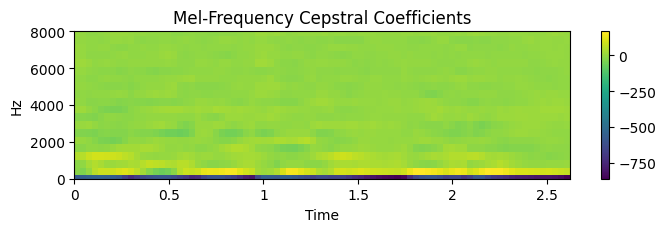

In [7]:
shape_y,shape_x = test['mel cepstral'].shape
shape_y = (width/shape_x)*shape_y

plt.figure(figsize=(width,shape_y),dpi=dpi)
ax=plt.subplot(111)
ld.specshow(test['mel cepstral'], sr=sample_rate, x_axis='time', y_axis='hz',cmap='viridis')
plt.title('Mel-Frequency Cepstral Coefficients')
plt.colorbar();

### Chromagram
Represents how the pitch changes over time.

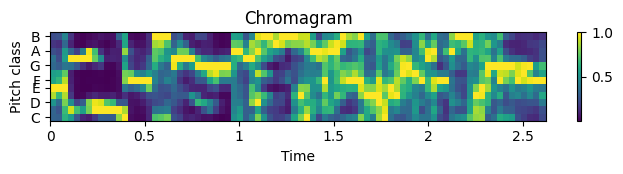

In [8]:
shape_y,shape_x = test['chroma'].shape
shape_y = (width/shape_x)*shape_y

plt.figure(figsize=(width,shape_y),dpi=dpi)
ld.specshow(test['chroma'], sr=sample_rate, x_axis='time', y_axis='chroma',cmap='viridis')
plt.title('Chromagram')
plt.colorbar();

### Spectral Centroid and Rolloff 
The centroid is the frequency that the spectrum is centered on, sort of like the ‘center of mass’ of the sound. The rolloff is a measurement of the shape of the signal.

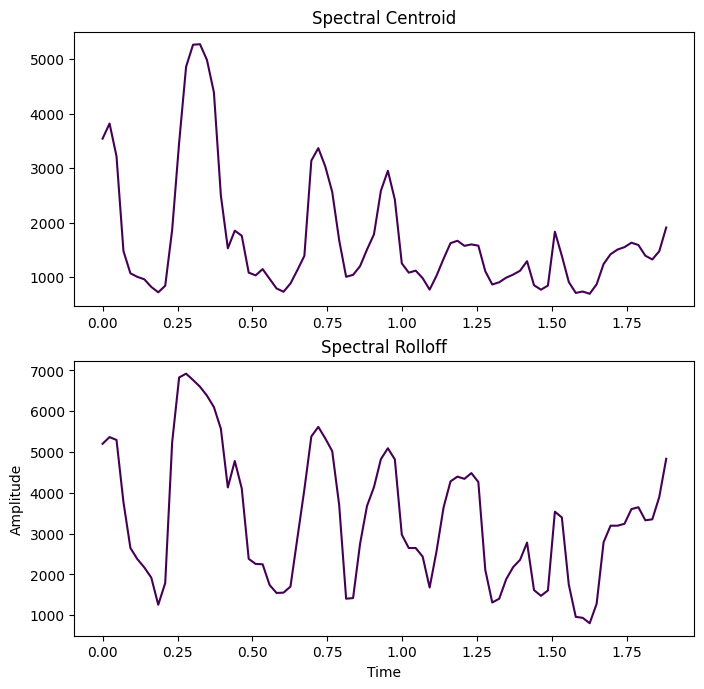

In [9]:
# set up time
x = test['rolloff'][0]
time = librosa.frames_to_time(range(len(x)))

plt.figure(figsize=(8,8),dpi=dpi)
plt.subplot(211)
plt.plot(time,test['centroid'][0],c=purple)
plt.title('Spectral Centroid')

plt.subplot(212)
plt.plot(time,test['rolloff'][0],c=purple)
plt.title('Spectral Rolloff')
plt.xlabel('Time')
plt.ylabel('Amplitude');

# Prep and Save
normalize the data feature-wise and add padding so that each entry is the same size.

In [10]:
# drop unnecessary
audio = audio.drop(columns=['audio','sample rate'])
# convert mel spectrogram to decibels
audio['mel spectrogram'] = [librosa.power_to_db(entry, ref=np.max) for entry in audio['mel spectrogram']]

In [11]:
def min_max(data,column):
    '''returns the global min and max of the whole column'''
    local_min = []
    local_max = []
    for entry in data[column]:
        local_min.append(np.amin(entry))
        local_max.append(np.amax(entry))
    return min(local_min), max(local_max)

# normalize by feature
def normalize(data,column):
    feat_min,feat_max = min_max(data,column)
    array = data[column].to_numpy()
    array = (array-feat_min)/(feat_max-feat_min)
    return array

def concat(data,columns):
    new_col = []
    for index in data.index:
        for column in columns:
            entry = audio.loc[index][column]
            if column == columns[0]:
                flat_entry = entry
            else:
                flat_entry = np.concatenate((flat_entry,entry),axis=0)
        new_col.append(flat_entry)
    return new_col

In [12]:
print('Normalizing Features',end='')
for column in columns[3:]:
    audio[column] = normalize(audio,column)
print(' - Complete!')

print('Combining Images',end='')
audio['final'] = concat(audio,columns[3:])
print('     - Complete!')

audio = audio.drop(columns=columns[3:])

print('Padding Images',end='')
max_len = 140
for index in audio.index:
    entry = audio.loc[index]['final']
    matrix = []
    if entry.shape[1] < max_len:
        zeros = max_len - entry.shape[1]
        front = int(zeros/2)
        back = int(zeros-front)
        for array in entry:
            matrix.append(np.append(np.append(np.zeros(front),array),np.zeros(back)))
    if entry.shape[1] == max_len:
        matrix = entry
    audio.loc[index]['final'] = matrix
print('       - Complete!')

Normalizing Features - Complete!
Combining Images     - Complete!
Padding Images       - Complete!


In [16]:
# save images
print('Saving Images')
for count,index in enumerate(audio.index,start=1):
    entry = audio.loc[index]
    path = 'Data/Images/%s.png' % (entry['filename'][:-4])
    plt.imsave(path,entry['final'])
    print('%4d of %d complete (%d%%)' % (count,len(audio.index),(count/len(audio.index))*100),end='\r')
print('%-30s' % ('Complete')) 

Saving Images
Complete                      
